# 15. Build Machine Learning models


## Final `CleanCorpusTransformer`
- To clean the corpus

In [ ]:
import re
import nltk
import pickle
import pandas as pd
from sklearn.base import TransformerMixin
from bs4 import BeautifulSoup
from nltk.stem import WordNetLemmatizer
from nltk.tag import pos_tag
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')

class CleanCorpusTransformer(TransformerMixin):
  """
  Transformer for cleaning and preprocessing text data.

  This transformer performs various operations such as removing punctuation,
  handling emojis, lemmatization, and stop word removal.

  If `emoji` is set to True, it loads emoticons from an HTML file.
  It also initializes a lemmatizer and a tag map for POS tagging.
  """
  def __init__(self, emoji:bool=False, stop_words:bool=False) -> None:
    """
    Initializes the CleanCorpusTransformer with options for emoji and stop words handling.

    If `emoji` is True, it loads emoticons from "/content/emoji.html".
    It first attempts to load emoticons from a cached file ("emoticons.pkl").
    If the file doesn't exist, it extracts emoticons from the HTML and caches them for future use.

    It also initializes a WordNetLemmatizer and a tag map for mapping POS tags
    to lemmatizer POS tags.

    Args:
        emoji (bool, optional): Whether to handle emojis. Defaults to False.
        stop_words (bool, optional): Whether to remove stop words. Defaults to False.
    """
    self.emoji: bool = emoji
    if stop_words:
      self.stop_words: set = set(stopwords.words('english'))
    else:
      self.stop_words: set = set()

    if emoji:
      try:
        with open("emoticons.pkl", "rb") as f:
          self.emoticons: dict = pickle.load(f)
      except FileNotFoundError:
        with open("/content/emoji.html", 'r', encoding='utf-8') as file:
          soup: BeautifulSoup = BeautifulSoup(file.read(), 'html.parser')
        self.emoticons: dict = self.extract_emotions(soup)
        with open("emoticons.pkl", "wb") as f:
          pickle.dump(self.emoticons, f)

    self.lemmatizer: WordNetLemmatizer = WordNetLemmatizer()
    self.tag_map: dict = {
        "VB": "v", "VBD": "v", "VBG": "v", "VBN": "v", "VBP": "v", "VBZ": "v",
        "JJ": "a", "JJR": "a", "JJS": "a",
        "RB": "r", "RBR": "r", "RBS": "r",
    }

  def remove_punctuation(self, x: str) -> list:
    """Removes punctuation from a text and returns a list of lowercase words.

    This method removes all characters that are not letters from the input text.
    It also converts all words to lowercase and filters out words with a length of 1 or less.

    Args:
        x (str): The text to remove punctuation from.

    Returns:
        list: A list of lowercase words with punctuation removed.
    """
    words: list = [word.lower() for word in re.sub("[^A-Za-z]", " ", x).split() if word.isalpha() and len(word) > 1]
    return words

  def postag_func(self, x: list) -> list:
    """Performs part-of-speech tagging on a list of words.

    This method uses the `pos_tag` function from NLTK to assign part-of-speech tags to each word in the input list.

    Args:
      x (list): A list of words.

    Returns:
      list: A list of tuples, where each tuple contains a word and its corresponding POS tag.
    """
    return pos_tag(x)

  def lemmatize_func(self, x: list) -> str:
    """Lemmatizes words based on their part-of-speech tags.

    This method uses the WordNetLemmatizer to reduce words to their base form (lemma).
    It uses a tag map to convert POS tags to the format expected by the lemmatizer.
    If a tag is not found in the map, it defaults to "n" (noun).

    Args:
      x (list): A list of (word, POS tag) tuples.

    Returns:
      str: A string containing the lemmatized words separated by spaces.
    """
    return " ".join([self.lemmatizer.lemmatize(word, pos=self.tag_map.get(tag, "n")) for word, tag in x])

  def extract_emotions(self, soup: BeautifulSoup) -> dict:
    """Extracts emoticons and their corresponding emotions from a BeautifulSoup object.

    This method iterates through the `<tr>` tags in the parsed HTML content, extracts the emoticon
    and its associated emotion, and stores them in a dictionary.

    Args:
      soup (BeautifulSoup): A BeautifulSoup object representing the parsed HTML content.

    Returns:
      dict: A dictionary where keys are emoticons and values are their corresponding emotions.
    """
    emoticons: dict = {}
    for tr_tag in soup.find_all('tr')[1:]:
      emote: str = tr_tag.td.text
      emotion: str = tr_tag.find_all("td")[-2].text.lower().replace(" ", "-")
      emoticons[emote]: str = f" {emotion} "
    return emoticons

  def emoticon_replace(self, x: str) -> str:
    """Replaces emoticons in a text with their corresponding emotions.

    This method iterates through the emoticons dictionary and replaces each emoticon
    found in the input text with its associated emotion. It then removes extra spaces.

    Args:
      x (str): The text containing emoticons.

    Returns:
      str: The text with emoticons replaced by emotions and extra spaces removed.
    """
    pattern: re = re.compile("|".join(re.escape(emoticon) for emoticon in self.emoticons))
    return pattern.sub(lambda match: self.emoticons[match.group(0)], x)

  def remove_punctuation_emoji(self, x: str) -> list:
    """Removes punctuation and converts text to lowercase, keeping hyphens.

    This method removes all characters that are not letters or hyphens from the input text.
    It converts all words to lowercase and filters out words with a length of 1 or less.

    Args:
      x (str): The text to process.

    Returns:
      list: A list of lowercase words with punctuation removed, but hyphens retained.
    """
    words: list = [word.lower() for word in re.sub("[^A-Za-z-]", " ", x).split() if len(word) > 1]
    return words

  def stopwords_remove(self, x: str) -> str:
    """Removes stop words from a text.

    This method removes common words (stop words) from the input text using a predefined set of stop words.

    Args:
      x (str): The text to remove stop words from.

    Returns:
      str: The text with stop words removed.
    """
    return " ".join([word for word in x.split() if word not in self.stop_words])

  def fit(self, X: pd.Series, y: pd.Series=None) -> "CleanCorpusTransformer":
    """Fits the transformer to the training data.

    This method preprocesses the input training data and creates a vocabulary (`self.train_vocab`)
    of unique words found in the cleaned text.

    Args:
      X (pd.Series or list-like): The training data.
      y: Ignored.

    Returns:
      self: The fitted transformer object.
    """
    cleaned_text: pd.Series = self.transform(X)
    self.train_vocab: set = {word for doc in cleaned_text for word in doc.split()}
    return self

  def transform(self, X: pd.Series, y: pd.Series =None) -> pd.Series:
    """
    Cleans and transforms the input text data.

    Applies various preprocessing steps to the input data, including:
      - Converting to a pandas Series if necessary
      - Applying the _process_text method to each element
      - Removing stop words if stop_words is True
      - Filtering words based on train_vocab if it exists

    Args:
        X (pd.Series or list-like): Input text data.
        y: Ignored.

    Returns:
        pd.Series: Transformed text data as a pandas Series.
    """
    if not isinstance(X, pd.Series):
      X: pd.Series = pd.Series(X)

    X = X.dropna()
    X_transformed: pd.Series = X.apply(self._process_text)

    if hasattr(self, 'train_vocab'):
      X_transformed = X_transformed.apply(lambda x: ' '.join([word for word in x.split() if word in self.train_vocab]))

    return X_transformed

  def _process_text(self, x: str) -> str:
    """Processes a single text element by applying various cleaning and transformation steps.

    This method performs the following steps:
      - If `self.emoji` is True, it replaces emoticons and removes punctuation, keeping hyphens.
      - Otherwise, it removes punctuation without keeping hyphens.
      - Performs part-of-speech tagging on the words.
      - Lemmatizes the words based on their POS tags.

    Args:
      x (str): The text element to process.

    Returns:
      str: The processed text as a string.
    """
    if self.emoji:
      x = self.emoticon_replace(x)
      x = self.remove_punctuation_emoji(x)
    else:
      x = self.remove_punctuation(x)
    x = self.postag_func(x)
    x = self.lemmatize_func(x)
    return x

  def get_params(self, deep: bool = True) -> dict:
    """
    Get parameters for this transformer.

    Args:
        deep (bool, optional): If True, will return the parameters for this
                                estimator and contained subobjects that are
                                estimators. Defaults to True.

    Returns:
        dict: Parameter names mapped to their values.
    """
    return {"emoji": self.emoji, "stop_words": self.stop_words}

  def set_params(self, **parameters) -> "CleanCorpusTransformer":
    """
    Set the parameters of this transformer.

    Args:
        **parameters: Parameter names with their new values.

    Returns:
        CleanCorpusTransformer: The transformer instance with updated parameters.
    """
    for parameter, value in parameters.items():
      setattr(self, parameter, value)
    return self

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Final `ManualWordToVector`
- To Perform manual word2vec

In [ ]:
import numpy as np
import pandas as pd
from typing import Union
from gensim.models import Word2Vec
from sklearn.base import TransformerMixin

class ManualWordToVector(TransformerMixin):
  """Transforms text data into numerical vectors using Word2Vec.

  This transformer trains a Word2Vec model on the input data and provides options
  for averaging word embeddings and padding sentences.
  """
  def __init__(self, twod=True, axis=0):
    """Initializes the ManualWordToVector transformer.

    Args:
      twod: Whether to return a 2D array (average embeddings) or a 3D array.
      axis: The axis along which to calculate the average (0 or 1) if twod is True.
    """
    self.twod = twod
    self.axis = axis

  def convert_to_list(self, x: pd.Series) -> list:
    """Converts a Pandas Series or a list of strings to a list of lists,
        where each sublist contains the tokens of a document.

    Args:
        x: A Pandas Series or a list of strings.

    Returns:
        A list of lists, where each sublist contains the tokens of a document.
        If input is already a list of lists it returns the same object

    Raises:
        TypeError: If input is not a Pandas Series or a list.
    """
    if isinstance(x, pd.Series):
      return x.apply(lambda x: x.split()).tolist()
    elif isinstance(x, list):
      return x
    else:
      raise TypeError("Input must be a Pandas Series or a list.")

  def train_w2v_model(self, x: list) -> Word2Vec:
    """Trains a Word2Vec model on the input data.

    Args:
        x: A list of lists, where each inner list represents the words
           of a document.

    Returns:
        A trained Word2Vec model.
    """
    trained_w2v = Word2Vec(x, window=5, min_count=1)
    return trained_w2v

  def extract_word_embedding(self, x: str) -> list:
    """Extracts word embeddings for each word in a string.

    Uses the trained Word2Vec model to extract embeddings.

    Args:
        x: A string representing a text document.

    Returns:
        A list of word embeddings for the words in the input string.
    """
    word_embedding_list = [self.trained_w2v.wv[word] for word in x if word in self.vocab]
    return word_embedding_list

  def apply_word2vec_to_series(self, x: pd.Series) -> list:
    """Applies the Word2Vec model to a pandas Series of text documents.

    Args:
        x: A pandas Series of text documents.

    Returns:
        A list of lists, where each inner list contains the word embeddings
        for a document.
    """
    embedded_sentences = [self.extract_word_embedding(item) for item in self.convert_to_list(x)]
    return embedded_sentences

  def avg_of_word2vec(self) -> np.ndarray:
    """Calculates the average word embedding for each document.

    Returns:
        A NumPy array where each row represents the average word embedding
        for a document.
    """
    return np.array([np.mean(item, axis=self.axis) for item in self.embedded_sentences])

  def fit(self, x: pd.Series):
    """Trains the Word2Vec model on the input data.

    Args:
        x: A pandas Series of text data.

    Returns:
        The transformer object itself (self).
    """
    list_of_docs = self.convert_to_list(x)
    self.trained_w2v = self.train_w2v_model(list_of_docs)
    self.vocab = self.trained_w2v.wv.index_to_key
    self.max_length = max(len(doc) for doc in list_of_docs)
    return self

  def transform(self, x: pd.Series) -> np.ndarray:
    """Transforms the input data using the trained Word2Vec model.

    Args:
        x: A pandas Series of text data.

    Returns:
        A NumPy array representing the transformed data.
    """
    if not hasattr(self, "trained_w2v"):
      raise ValueError("Model not fitted. Please call fit() first.")
    self.embedded_sentences = self.apply_word2vec_to_series(x)

    padded_sentences = []
    for sentence in self.embedded_sentences:
      if len(sentence) < self.max_length:
        padding = [[0] * self.trained_w2v.vector_size] * (self.max_length - len(sentence))
        sentence = sentence + padding
      padded_sentences.append(sentence)
    self.embedded_sentences = padded_sentences

    if self.twod:
      return self.avg_of_word2vec()
    else:
      return np.array(self.embedded_sentences)

  def fit_transform(self, x: pd.Series, y: Union[pd.Series, None] = None) -> np.ndarray:
    """Fit the transformer and transform the input data.

    Fits the Word2Vec model and transforms the input text data into word embeddings.

    Args:
        X: A Pandas Series containing the text data.
        y: Ignored. This parameter exists for compatibility with scikit-learn pipelines.

    Returns:
        A NumPy array containing the word embeddings. If `self.twod` is True,
        returns the average word embeddings for each document. If `self.twod` is
        False, returns the padded embedded sentences.
    """
    self.fit(x)
    return self.transform(x)

  def get_params(self, deep=True):
    """Gets parameters for this estimator.

    Args:
        deep (bool): If True, will return the parameters for this estimator and
            contained subobjects that are estimators.

    Returns:
        dict: Parameter names mapped to their values.
    """
    return {"twod": self.twod, "axis": self.axis}

  def set_params(self, **parameters):
    """Set the parameters of this estimator.

    Args:
        **parameters: Estimator parameters.

    Returns:
        self: Estimator instance.
    """
    for parameter, value in parameters.items():
      setattr(self, parameter, value)
    return self

## Final `PretrainedWordToVector`
- To use pre-trained word2vec

In [ ]:
import gensim
import numpy as np
import pandas as pd
from typing import Optional, Union
from gensim.models import KeyedVectors
from sklearn.base import TransformerMixin
class PretrainedWordToVector(TransformerMixin):
  """
    Transforms text data using pre-trained word embeddings.

    This class allows you to load pre-trained word embedding models
    and use them to transform text data into numerical representations.
    It supports loading models from separate model and vector files or using
    a pre-loaded Gensim model. It also provides options for padding and
    dimensionality reduction.
    """
  def __init__(self, model_file: Optional[str] = None, vectors_file: Optional[str] = None,
                twod: bool = True, axis: int = 0,
                gensim_model: Optional[gensim.models.keyedvectors.KeyedVectors] = None,
                padding: str = "pre", batch_size: Optional[int] = None):
    """
    Initializes PretrainedWordToVector.

    Parameters
    ----------
    model_file : str, optional
        Path to the word embedding model file.
    vectors_file : str, optional
        Path to the word vectors file.
    twod : bool, default=True
        Whether to reduce the dimensionality to two dimensions.
    axis : int, default=0
        Axis along which to calculate the mean for dimensionality reduction.
    gensim_model : gensim.models.keyedvectors.KeyedVectors, optional
        Pre-loaded Gensim word embedding model.
    padding : str, default="pre"
        Type of padding to use ("pre" or "post").
    batch_size : int, optional
        Batch size for processing data (None for no batching).
    """
    self.model_file = model_file
    self.vectors_file = vectors_file
    self.gensim_model = gensim_model
    self.twod = twod
    self.axis = axis
    self.wv = None  # Initialize wv here
    self.padding = padding
    self.batch_size = batch_size

  def convert_to_list(self, x: pd.Series) -> list:
    """
    Converts input data to a list of lists.

    Parameters
    ----------
    x : pd.Series
        Input data as a Pandas Series.

    Returns
    -------
    list
        List of lists, where each inner list represents a document as a list of words.
    """
    if isinstance(x, pd.Series):
      return [doc.split() for doc in x] # Optimized code
    elif isinstance(x, list):
      return x
    else:
      raise TypeError("Input must be a Pandas Series or a list.")

  def gensim_model_vectors(self) -> gensim.models.keyedvectors.KeyedVectors:
    """
    Loads word vectors from model and vectors files or uses a pre-loaded model.

    Returns
    -------
    gensim.models.keyedvectors.KeyedVectors
        Loaded word vectors.
    """
    if (self.model_file) and (self.vectors_file):
      self.wv = KeyedVectors.load(self.model_file, mmap='r')
      self.wv.vectors = np.load(self.vectors_file, mmap_mode="r")
    else:
      self.wv = self.gensim_model
    return self.wv

  def perform_w2v(self, x: list) -> list:
    """
    Performs word embedding lookup for a given sentence.

    Parameters
    ----------
    x : list
        Input sentence as a list of words.

    Returns
    -------
    list
        List of word embeddings for the input sentence.
    """
    # Optimized code
    sent_norm = [self.wv[word]
                  for word in x
                  if word in self.wv and word in self.train_vocab]
    return sent_norm

  def fit(self, X: pd.Series, y: None = None) -> "PretrainedWordToVector":
    """
    Fits the transformer on the input data.

    Parameters
    ----------
    X : pd.Series
        Input data as a Pandas Series.
    y : Ignored
        Not used, present here for compatibility with scikit-learn API.

    Returns
    -------
    self
        Fitted transformer.
    """
    list_of_docs = self.convert_to_list(X)
    self.train_vocab = {word for sent in list_of_docs for word in sent}
    self.max_length = max(len(doc) for doc in list_of_docs)

    return self

  def transform(self, X: pd.Series, y: None = None) -> Union[np.ndarray, np.ndarray]:
    """
    Transforms the input data using the loaded word vectors.

    Performs word embedding lookup for each sentence in the input data.
    Handles out-of-vocabulary words and applies padding to ensure
    consistent sentence lengths. Optionally performs dimensionality
    reduction by calculating the mean of the word embeddings.

    Supports batch processing for large datasets.

    Parameters
    ----------
    X : pd.Series
        Input data as a Pandas Series.
    y : Ignored
        Not used, present here for compatibility with scikit-learn API.

    Returns
    -------
    Union[np.ndarray, np.ndarray]
        Transformed data. If `self.twod` is True, it returns a 2D array of mean
        embeddings (dimensionality reduction). Otherwise, it returns the full 3D
        array of padded embeddings.
    """
    if not hasattr(self, "train_vocab"):
      raise ValueError("Model not fitted. Please call fit() first.")

    if self.wv is None:
      # Load the model in transform if it's not already loaded
      self.gensim_model_vectors()

    list_of_docs = self.convert_to_list(X)

    if self.batch_size is None:
      pt_word2vec = [self.perform_w2v(sent) for sent in list_of_docs]
    else:
      pt_word2vec = []
      for i in range(0, len(list_of_docs), self.batch_size):
        batch = list_of_docs[i : i + self.batch_size]
        pt_word2vec.extend([self.perform_w2v(sent) for sent in batch])

    padded_embeddings = np.zeros((len(pt_word2vec), self.max_length, self.wv.vector_size))
    for i, sent in enumerate(pt_word2vec):
      if sent:
        if self.padding == 'post':
          padded_embeddings[i, :len(sent)] = sent
        elif self.padding == 'pre':
          padded_embeddings[i, -len(sent):] = sent
        else:
          raise ValueError("Invalid padding type. Choose 'pre' or 'post'.")

    if self.twod:
      return np.array([np.mean(item, axis=self.axis) for item in padded_embeddings])
    else:
      return padded_embeddings

  def get_params(self, deep=True):
    """
    Get parameters for this estimator.

    Parameters
    ----------
    deep : bool, default=True
        If True, will return the parameters for this estimator and
        contained subobjects that are estimators.

    Returns
    -------
    params : dict
        Parameter names mapped to their values.
    """
    return {
        "model_file": self.model_file,
        "vectors_file": self.vectors_file,
        "twod": self.twod,
        "axis": self.axis,
        "batch_size": self.batch_size,
        "padding": self.padding,
    }

  def set_params(self, **parameters):
    """
    Set the parameters of this estimator.

    The method works on simple estimators as well as on nested objects
    (such as pipelines). The latter have parameters of the form
    ``<component>__<parameter>`` such that one can update each
    component of a nested object.

    Parameters
    ----------
    **parameters : dict
        Parameter names mapped to their values.

    Returns
    -------
    self : estimator instance
        Estimator instance.
    """
    for parameter, value in parameters.items():
      setattr(self, parameter, value)
    return self

## Final `WordVectors`
- To integret `CleanCorpusTransformer`, `ManualWordToVector` and `PretrainedWordToVector`

In [ ]:
import numpy as np
import pandas as pd
import scipy
from typing import Union, Tuple
from sklearn.base import TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

class WordVectors(TransformerMixin):
  """
  Transforms a text corpus into numerical word vectors.

  This class provides a flexible way to vectorize text data using different
  techniques, including CountVectorizer, TfidfVectorizer, ManualWordToVector,
  and PretrainedWordToVector. It also incorporates text cleaning using the
  CleanCorpusTransformer.

  Args:
      vectorizer (str, optional): The vectorization method to use.
                                  Options are 'count', 'tfidf', 'manualw2v',
                                  or 'pretrainedw2v'. Defaults to 'count'.
      emoji (bool, optional): Whether to consider emojis during cleaning.
                              Defaults to False.
      stop_words (bool, optional): Whether to remove stop words during cleaning.
                                  Defaults to False.

  Attributes:
      cleaner (CleanCorpusTransformer): The transformer for cleaning the corpus.
      vectorizer: The vectorizer object (CountVectorizer, TfidfVectorizer,
                  ManualWordToVector, or PretrainedWordToVector).
  """
  def __init__(
      self, vectorizer: str = "count", emoji: bool = False, stop_words: bool = False
  ) -> None:
    """
    Initializes the WordVectors transformer.

    Creates a CleanCorpusTransformer for text cleaning and initializes
    the specified vectorizer based on the `vectorizer` argument.

    Args:
        vectorizer (str, optional): The type of vectorizer to use.
                                    Options are 'count', 'tfidf', 'manualw2v',
                                    or 'pretrainedw2v'. Defaults to 'count'.
        emoji (bool, optional): Whether to handle emojis during cleaning.
                                Defaults to False.
        stop_words (bool, optional): Whether to remove stop words during cleaning.
                                    Defaults to False.
    """
    self.cleaner = CleanCorpusTransformer(emoji=emoji, stop_words=stop_words)
    self.vectorizer = self._init_vectorizer(vectorizer)

  def _init_vectorizer(self, vectorizer_type: str):
    """
    Initializes the specified vectorizer based on the `vectorizer_type` argument.

    Args:
        vectorizer_type (str): The type of vectorizer to initialize.

    Returns:
        An instance of the specified vectorizer (CountVectorizer,
        TfidfVectorizer, ManualWordToVector, or PretrainedWordToVector).

    Raises:
        ValueError: If an invalid `vectorizer_type` is provided.
    """
    if vectorizer_type == "count":
      return CountVectorizer(binary=True)
    elif vectorizer_type == "tfidf":
      return TfidfVectorizer(binary=True)
    elif vectorizer_type == "manualw2v":
      return ManualWordToVector()
    elif vectorizer_type == "pretrainedw2v":
      return PretrainedWordToVector()
    else:
      raise ValueError(f"Invalid vectorizer type: {vectorizer_type}. Choose from: 'count', 'tfidf', 'manualw2v', 'pretrainedw2v'.")

  def fit(self, corpus: pd.Series, y:Union[pd.Series, None]=None) -> "WordVectors":
    """
    Fits the WordVectors transformer on the corpus.

    This method cleans the corpus using the CleanCorpusTransformer and then
    fits the specified vectorizer to the cleaned data.

    Args:
        corpus (pd.Series): The text data to fit the transformer on.

    Returns:
        WordVectors: The fitted transformer object.
    """
    cleaned_corpus = self.cleaner.fit_transform(corpus)
    if (self.vectorizer=="manualw2v") or (self.vectorizer=="pretrainedw2v"):
      cleaned_corpus = cleaned_corpus.apply(lambda x: x.split()).tolist()
      self.vectorizer.fit(cleaned_corpus)
    else:
      self.vectorizer.fit(cleaned_corpus)
    return self
    # if isinstance(self.vectorizer, ManualWordToVector) or isinstance(self.vectorizer, PretrainedWordToVector):
    #   cleaned_corpus = cleaned_corpus.apply(lambda x: x.split()).tolist()
    #   self.vectorizer.fit(cleaned_corpus)
    # else:
    #   self.vectorizer.fit(cleaned_corpus)
    # return self

  def transform(
      self, corpus: pd.Series, y:Union[pd.Series, None]=None
  ) -> Union[scipy.sparse.csr_matrix, np.ndarray, Tuple[np.ndarray, pd.Series]]:
    """
    Transforms the corpus into word vectors.

    This method cleans the corpus using the CleanCorpusTransformer and then
    transforms the cleaned data into word vectors using the specified
    vectorizer.

    Args:
        corpus (pd.Series): The text data to be transformed.

    Returns:
        The word vectors in the appropriate format (scipy.sparse.csr_matrix,
        np.ndarray, or a tuple of np.ndarray and pd.Series).
    """
    cleaned_corpus = self.cleaner.transform(corpus)
    if (self.vectorizer=="manualw2v") or (self.vectorizer=="pretrainedw2v"):
      cleaned_corpus = cleaned_corpus.apply(lambda x: x.split()).tolist()
      word_vectors = self.vectorizer.transform(cleaned_corpus) # Explicitly set twod and threed
    else:
      word_vectors = self.vectorizer.transform(cleaned_corpus)
    return word_vectors

## Final `ClassWeightsTransformer`
- To Provide class weights to handle class imbalance

In [ ]:
import numpy as np
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, balanced_accuracy_score, precision_score, recall_score
from sklearn.base import TransformerMixin
from sklearn.model_selection import train_test_split

class ClassWeightsTransformer(TransformerMixin):
  """
  Transformer for calculating and applying class weights to address class imbalance.

  This transformer determines the best class weighting method based on a
  specified evaluation metric and applies the corresponding weights during model training.

  Parameters
  ----------
  model : estimator object, default=LogisticRegression()
      The base model used to evaluate different weighting methods.
  metric : str, default='f1_weighted'
      The evaluation metric used to select the best weighting method.
  neutral_boost : float, default=2.0
      A multiplier for the weight of the neutral class (class 1).

  Attributes
  ----------
  classes_ : ndarray of shape (n_classes,)
      The classes labels.
  counts_ : ndarray of shape (n_classes,)
      The number of samples in each class.
  num_classes_ : int
      The number of classes.
  weights_ : dict
      The best class weights found during fitting.
  """
  def __init__(self, model=LogisticRegression(), metric='f1_weighted', neutral_boost=2.0):
    """
    Initializes the ClassWeightsTransformer with a model, metric, and boost factor.

    Args:
        model (estimator): A scikit-learn estimator for score calculation
                            (default: LogisticRegression).
        metric (str): Evaluation metric used for score calculation
                      (default: 'f1_weighted').
        neutral_boost (float): Boost factor for neutral class weight
                                (default: 2.0).
    """
    self.model = model
    self.metric = metric
    self.neutral_boost = neutral_boost
    self.weights_ = None

  def fit(self, X, y):
    """
    Fit the transformer to the data and determine the best class weights.

    Parameters
    ----------
    X : array-like of shape (n_samples, n_features)
        The training input samples.
    y : array-like of shape (n_samples,)
        The target values.

    Returns
    -------
    self : object
        Returns self.
    """
    self.classes_, self.counts_ = np.unique(y, return_counts=True)
    self.X = X
    self.y = y
    self.num_classes_ = len(self.classes_)
    self.find_best_weights(X, y)  # Call find_best_weights here
    return self

  def transform(self, X):
    """
    Transform the data - does not apply any transformation in this case.

    Parameters
    ----------
    X : array-like of shape (n_samples, n_features)
        The input samples.

    Returns
    -------
    X : array-like of shape (n_samples, n_features)
        The unchanged input samples.
    """
    return X  # No modification in transform

  def find_best_weights(self, X, y, num_iterations=5, score_range=(0.1, 0.9)):
    """
    Determines the best class weighting method for the given data and model.

    This method performs a search to identify the optimal class weighting
    strategy for the provided dataset and model. It evaluates different
    weighting techniques and selects the one that yields the highest score
    based on the specified evaluation metric.

    The search process involves two main steps:

    1. **Random Score Optimization:**
        - Generates random scores for each class within a specified range.
        - Calculates class weights using the `score_weighted` method with
          these random scores.
        - Trains the model using these weights and evaluates its performance
          on a validation set.
        - Repeats this process for a defined number of iterations, storing
          the scores that result in the best average score.

    2. **Weighting Method Evaluation:**
        - Evaluates a set of predefined weighting methods:
          - `balanced`: Assigns weights inversely proportional to class
            frequencies.
          - `sqrt_inv_freq_weights`: Assigns weights inversely proportional
            to the square root of class frequencies.
          - `effective_sample_size_weights`: Calculates weights based on
            effective sample size.
          - `inverse_weights`: Assigns weights inversely proportional to the
            best scores found in the random score optimization step.
        - For each method, calculates class weights, trains the model, and
          evaluates its performance on the validation set.

    After evaluating all methods, the method with the highest score is
    selected, and its corresponding weights are stored in the `weights_`
    attribute.

    Args:
        num_iterations (int, optional): The number of iterations for random
                                        score search (default: 5).
        score_range (tuple, optional): The range for generating random
                                        scores (default: (0.1, 0.9)).

    """
    best_method = None
    best_weights = None
    best_score = 0

    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    best_scores = None
    best_avg_score = 0

    model = self.model.__class__()

    for _ in range(num_iterations):
      scores = [random.uniform(*score_range) for _ in range(self.num_classes_)]
      class_weights = self.score_weighted(scores)
      sample_weights = np.array([class_weights[y] for y in y_train])
      model.fit(X_train, y_train, sample_weight=sample_weights)
      y_pred = model.predict(X_val)

      scores_after_training = [class_weights[i] * self.counts_[i] for i in range(self.num_classes_)]
      avg_score = np.mean(scores_after_training)

      if avg_score > best_avg_score:
          best_avg_score = avg_score
          best_scores = scores

    methods = [
        self.balanced,
        self.sqrt_inv_freq_weights,
        self.effective_sample_size_weights,
        lambda: self.inverse_weights(best_scores),
        ]

    for method in methods:
      weights = method()
      sample_weights = np.array([weights[y] for y in y_train])
      model = self.model.__class__()
      model.fit(X_train, y_train, sample_weight=sample_weights)
      y_pred = model.predict(X_val)
      score = self._evaluate(y_val, y_pred)

      if score > best_score:
          best_score = score
          best_method = method.__name__
          best_weights = weights

    self.weights_ = best_weights
    print(f"Best weights: {self.weights_}")

  def balanced(self):
    """
    Calculate balanced class weights.

    Returns
    -------
    class_weight_dict : dict
        Dictionary of class weights.
    """
    class_weights = 1.0 / self.counts_
    normalized_weights = class_weights / np.sum(class_weights)
    class_weight_dict = {i: weight for i, weight in enumerate(normalized_weights)}
    return class_weight_dict

  def sqrt_inv_freq_weights(self):
    """
    Calculate class weights using the square root of inverse frequency.

    Returns
    -------
    class_weight_dict : dict
        Dictionary of class weights.
    """
    weights = 1.0 / np.sqrt(self.counts_)
    normalized_weights = weights / np.sum(weights)
    class_weight_dict = {i: weight for i, weight in enumerate(normalized_weights)}
    return class_weight_dict

  def effective_sample_size_weights(self, beta=0.9999):
    """
    Calculate class weights using effective sample size.

    Parameters
    ----------
    beta : float, default=0.9999
        Parameter for effective sample size calculation.

    Returns
    -------
    class_weight_dict : dict
        Dictionary of class weights.
    """
    effective_num = 1.0 - np.power(beta, self.counts_)
    weights = (1.0 - beta) / np.array(effective_num)
    normalized_weights = weights / np.sum(weights)
    class_weight_dict = {i: weight for i, weight in enumerate(normalized_weights)}
    return class_weight_dict

  def score_weighted(self, scores):
    """
    Calculate class weights based on scores.

    Parameters
    ----------
    scores : list
        List of scores for each class.

    Returns
    -------
    class_weight_dict : dict
        Dictionary of class weights.
    """
    weighted_score = scores * self.counts_
    inv_weighted_score = 1.0 / weighted_score
    normalized_weights = inv_weighted_score / np.sum(inv_weighted_score)
    class_weight_dict = {i: weight for i,weight in enumerate(normalized_weights)}
    return class_weight_dict

  def inverse_weights(self, scores):
    """
    Calculate inverse class weights based on scores and apply neutral boost.

    Parameters
    ----------
    scores : list
        List of scores for each class.

    Returns
    -------
    class_weight_dict : dict
        Dictionary of class weights.
    """
    scores = np.array(scores)
    class_weights = 1.0 / scores
    normalized_weights = class_weights / np.sum(class_weights)
    class_weight_dict = {i: weight for i, weight in enumerate(normalized_weights)}

    class_weight_dict[1] = class_weight_dict[1] * self.neutral_boost
    if self.neutral_boost != 1:
      normalized_weights = np.array(list(class_weight_dict.values())) / np.sum(
          list(class_weight_dict.values())
      )
      class_weight_dict = {i: weight for i, weight in enumerate(normalized_weights)}

    return class_weight_dict

  def _evaluate(self, y_true, y_pred):
    """
    Evaluate the model using the specified metric.

    Parameters
    ----------
    y_true : array-like of shape (n_samples,)
        True labels.
    y_pred : array-like of shape (n_samples,)
        Predicted labels.

    Returns
    -------
    score : float
        The evaluation score.
    """
    metrics = {
        'accuracy': lambda y_true, y_pred: accuracy_score(y_true, y_pred),
        'balanced_accuracy': lambda y_true, y_pred: balanced_accuracy_score(y_true, y_pred),
        'f1_macro': lambda y_true, y_pred: f1_score(y_true, y_pred, average='macro'),
        'f1_micro': lambda y_true, y_pred: f1_score(y_true, y_pred, average='micro'),
        'f1_samples': lambda y_true, y_pred: f1_score(y_true, y_pred, average='samples'),
        'f1_weighted': lambda y_true, y_pred: f1_score(y_true, y_pred, average='weighted'),
        'precision_weighted': lambda y_true, y_pred: precision_score(y_true, y_pred, average='weighted'),
        'recall_weighted': lambda y_true, y_pred: recall_score(y_true, y_pred, average='weighted'),
    }

    metric_func = metrics.get(self.metric)
    if metric_func:
      return metric_func(y_true, y_pred)
    else:
      raise ValueError(f"Invalid metric: {self.metric}")

  def get_params(self, deep=True):
    """
    Get parameters for this estimator.

    Parameters
    ----------
    deep : bool, default=True
        If True, return the parameters for this estimator and
        contained subobjects that are estimators.

    Returns
    -------
    params : dict
        Parameter names mapped to their values.
    """
    return {
        'model': self.model,
        'metric': self.metric,
        'neutral_boost': self.neutral_boost,
    }

  def set_params(self, **parameters):
    """
    Set the parameters of this estimator.

    The method works on simple estimators as well as on nested objects
    (such as pipelines). The latter have parameters of the form
    ``<component>__<parameter>`` so that it's possible to update each
    component of a nested object.

    Parameters
    ----------
    **parameters : dict
        Estimator parameters.

    Returns
    -------
    self : estimator instance
        Estimator instance.
    """
    for parameter, value in parameters.items():
      setattr(self, parameter, value)
    return self

## Import train and validation datasets

### Import reviews train dataset

In [ ]:
flipkart_train_reviews = pd.read_csv("/content/flipkart_train_reviews.csv")
flipkart_train_reviews.head()

,reviews,ratings,sentiments,no_emoji_reviews,yes_emoji_reviews,no_stopwords_reviews
0,All is well\nBest and comfortable,5.0,positive,all be well best and comfortable,all be well best and comfortable,well best comfortable
1,Awesome ear buds\nAll over fine and good,5.0,positive,awesome ear bud all over fine and good,awesome ear bud all over fine and good,awesome ear bud fine good
2,Battery charging issue. Need to press earphone...,2.0,negative,battery charge issue need to press earphone ag...,battery charge issue need to press earphone ag...,battery charge issue need press earphone charg...
3,I really like the design and lighting effects....,5.0,positive,really like the design and lighting effect it ...,really like the design and lighting effect it ...,really like design lighting effect feel like b...
4,Sound and bass quality is good.,4.0,positive,sound and bass quality be good,sound and bass quality be good,sound bass quality good


In [ ]:
flipkart_train_reviews.shape

(25850, 6)

In [ ]:
flipkart_train_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25850 entries, 0 to 25849
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   reviews               25850 non-null  object 
 1   ratings               25850 non-null  float64
 2   sentiments            25850 non-null  object 
 3   no_emoji_reviews      25849 non-null  object 
 4   yes_emoji_reviews     25850 non-null  object 
 5   no_stopwords_reviews  25829 non-null  object 
dtypes: float64(1), object(5)
memory usage: 1.2+ MB


In [ ]:
flipkart_train_reviews.isnull().sum()

,0
reviews,0
ratings,0
sentiments,0
no_emoji_reviews,1
yes_emoji_reviews,0
no_stopwords_reviews,21


### Import reviews validation dataset

In [ ]:
flipkart_valid_reviews = pd.read_csv("/content/flipkart_validation_reviews.csv")
flipkart_valid_reviews.head()

,reviews,ratings,sentiments,no_emoji_reviews,yes_emoji_reviews,no_stopwords_reviews
0,If anybody is planning to add a soundbar to th...,5,positive,if anybody be plan to add soundbar to their sm...,if anybody be plan to add soundbar to their sm...,anybody plan add soundbar smart tv close eye g...
1,After long searching I found a excellent sound...,5,positive,after long search find excellent sound bar und...,after long search find excellent sound bar und...,long search find excellent sound bar good bass...
2,Really the product is the value of money.Super...,5,positive,really the product be the value of money super...,really the product be the value of money super...,really product value money superior sound qual...
3,Hello everyone!\n\nI have used music products ...,5,positive,hello everyone have use music product which co...,hello everyone have use music product which co...,hello everyone use music product cost way lacs...
4,Sound quality is superb,5,positive,sound quality be superb,sound quality be superb,sound quality superb


In [ ]:
flipkart_valid_reviews.shape

(5684, 6)

In [ ]:
flipkart_valid_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5684 entries, 0 to 5683
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviews               5684 non-null   object
 1   ratings               5684 non-null   int64 
 2   sentiments            5684 non-null   object
 3   no_emoji_reviews      5684 non-null   object
 4   yes_emoji_reviews     5684 non-null   object
 5   no_stopwords_reviews  5679 non-null   object
dtypes: int64(1), object(5)
memory usage: 266.6+ KB


In [ ]:
flipkart_valid_reviews.isnull().sum()

,0
reviews,0
ratings,0
sentiments,0
no_emoji_reviews,0
yes_emoji_reviews,0
no_stopwords_reviews,5


### Extract `train` and `validation` reviews

In [ ]:
train_reviews = flipkart_train_reviews["reviews"].copy()
valid_reviews = flipkart_valid_reviews["reviews"].copy()

### Extract `train` and `validation` labels

In [ ]:
train_sentiments = flipkart_train_reviews["sentiments"].copy()
valid_sentiments = flipkart_valid_reviews["sentiments"].copy()

## Import relevant libraries

In [ ]:
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

## Labels

### Train labels

In [ ]:
le = LabelEncoder()

In [ ]:
train_labels = le.fit_transform(y=train_sentiments)
train_labels

array([2, 2, 0, ..., 2, 2, 2])

In [ ]:
np.unique(train_labels)

array([0, 1, 2])

### Validation labels

In [ ]:
valid_labels = le.transform(y=valid_sentiments)
valid_labels

array([2, 2, 2, ..., 2, 1, 2])

In [ ]:
np.unique(valid_labels)

array([0, 1, 2])

## Count Vectorizer

### Emoji - No

#### Class Weights - Not Balanced

##### Create pipeline - `pipe_eno_cv`

In [ ]:
pipe_eno_cv = Pipeline(
                        [
                          ("Clean_Corpus", CleanCorpusTransformer(emoji=False, stop_words=False)),
                          ("Word_Vectorizer", WordVectors(vectorizer="count")),
                          ("Scaler", StandardScaler(with_mean=False)), # For sparse matrix it should be "with_mean=False"
                          ("Classifier", LogisticRegression(max_iter=1000))
                        ]
                      )

##### Fit pipeline - `pipe_eno_cv`

In [ ]:
%%time
# CPU times: user 2min 42s, sys: 12.4 s, total: 2min 55s
# Wall time: 2min 38s
pipe_eno_cv.fit(X=train_reviews, y=train_labels)

CPU times: user 2min 49s, sys: 13.2 s, total: 3min 2s
Wall time: 2min 46s


Pipeline(steps=[('Clean_Corpus',
                 <__main__.CleanCorpusTransformer object at 0x7ce1f5310fd0>),
                ('Word_Vectorizer',
                 <__main__.WordVectors object at 0x7ce1f5311630>),
                ('Scaler', StandardScaler(with_mean=False)),
                ('Classifier', LogisticRegression(max_iter=1000))])

##### Predict validation data

In [ ]:
%%time
valid_pred_eno_cv = pipe_eno_cv.predict(X=valid_reviews)
valid_pred_eno_cv

CPU times: user 12.8 s, sys: 207 ms, total: 13 s
Wall time: 13 s


array([2, 2, 2, ..., 0, 0, 2])

##### Metrics

- Confusion Matrix

In [ ]:
le.classes_

array(['negative', 'neutral', 'positive'], dtype=object)

- There's no direct method within `LabelEncoder` to retrieve the classes as integers instead of their original form, you can achieve this by combining `classes_` and `transform`:

```
from sklearn.preprocessing import LabelEncoder

# Sample labels
labels = ['cat', 'dog', 'cat', 'bird']

# Initialize the encoder
le = LabelEncoder()

# Fit the encoder
le.fit(labels)

# Get integer representation of classes
integer_classes = le.transform(le.classes_)

print(f"Classes in integer form: {integer_classes}")
```

In [ ]:
cm = confusion_matrix(y_true=valid_labels,
                      y_pred=valid_pred_eno_cv,
                      labels=np.unique(valid_labels))
print(f"Confusion Matrix:\n\n{cm}")

Confusion Matrix:

[[ 249   74  187]
 [  76   64  332]
 [ 159  209 4334]]


- Create a heatmap for better visualization

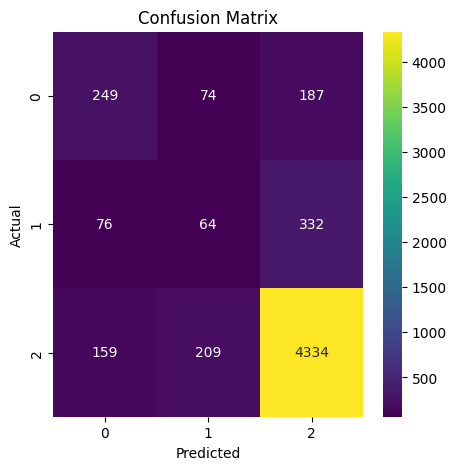

In [ ]:
plt.figure(figsize=(5,5))
sb.heatmap(cm, annot=True, fmt="d", cmap="viridis",
            xticklabels=np.unique(valid_labels),
            yticklabels=np.unique(valid_labels))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

- Classification Report

In [ ]:
print(f"""Classification Report:\n\n{classification_report(y_true=valid_labels,
                                                         y_pred=valid_pred_eno_cv,
                                                         target_names=le.classes_)}""")

Classification Report:

              precision    recall  f1-score   support

    negative       0.51      0.49      0.50       510
     neutral       0.18      0.14      0.16       472
    positive       0.89      0.92      0.91      4702

    accuracy                           0.82      5684
   macro avg       0.53      0.52      0.52      5684
weighted avg       0.80      0.82      0.81      5684



#### Class Weights - Balanced

##### Create pipeline - `pipe_eno_cv_bal`

In [ ]:
pipe_eno_cv_bal = Pipeline(
                        [
                          ("Clean_Corpus", CleanCorpusTransformer(emoji=False, stop_words=False)),
                          ("Word_Vectorizer", WordVectors(vectorizer="count")),
                          ("Scaler", StandardScaler(with_mean=False)), # For sparse matrix it should be "with_mean=False"
                          ("Classifier", LogisticRegression(max_iter=1000, class_weight="balanced"))
                        ]
                      )

##### Fit pipeline - `pipe_eno_cv_bal`

In [ ]:
%%time
# CPU times: user 2min 49s, sys: 13.6 s, total: 3min 2s
# Wall time: 2min 45s
pipe_eno_cv_bal.fit(X=train_reviews, y=train_labels)

CPU times: user 2min 49s, sys: 13.6 s, total: 3min 2s
Wall time: 2min 45s


Pipeline(steps=[('Clean_Corpus',
                 <__main__.CleanCorpusTransformer object at 0x7ce1f53139d0>),
                ('Word_Vectorizer',
                 <__main__.WordVectors object at 0x7ce1f53106a0>),
                ('Scaler', StandardScaler(with_mean=False)),
                ('Classifier',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

##### Predict validation data

In [ ]:
%%time
valid_pred_cv_eno_bal = pipe_eno_cv_bal.predict(X=valid_reviews)
valid_pred_cv_eno_bal

CPU times: user 12.2 s, sys: 209 ms, total: 12.4 s
Wall time: 12.5 s


array([2, 2, 2, ..., 0, 0, 2])

##### Metrics

- Confusion Matrix

In [ ]:
le.classes_

array(['negative', 'neutral', 'positive'], dtype=object)

- There's no direct method within `LabelEncoder` to retrieve the classes as integers instead of their original form, you can achieve this by combining `classes_` and `transform`:

```
from sklearn.preprocessing import LabelEncoder

# Sample labels
labels = ['cat', 'dog', 'cat', 'bird']

# Initialize the encoder
le = LabelEncoder()

# Fit the encoder
le.fit(labels)

# Get integer representation of classes
integer_classes = le.transform(le.classes_)

print(f"Classes in integer form: {integer_classes}")
```

In [ ]:
cm = confusion_matrix(y_true=valid_labels,
                      y_pred=valid_pred_cv_eno_bal,
                      labels=np.unique(valid_labels))
print(f"Confusion Matrix:\n\n{cm}")

Confusion Matrix:

[[ 274  108  128]
 [  94  108  270]
 [ 252  610 3840]]


- Create a heatmap for better visualization

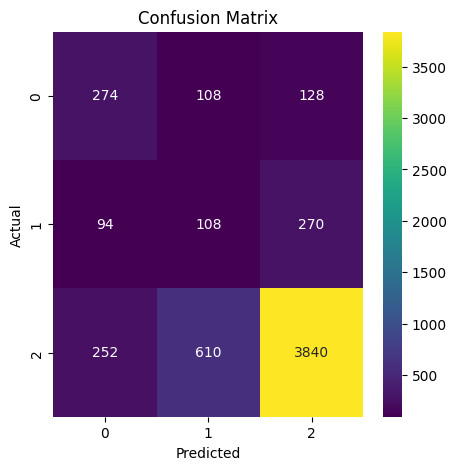

In [ ]:
plt.figure(figsize=(5,5))
sb.heatmap(cm, annot=True, fmt="d", cmap="viridis",
            xticklabels=np.unique(valid_labels),
            yticklabels=np.unique(valid_labels))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

- Classification Report

In [ ]:
print(f"""Classification Report:\n\n{classification_report(y_true=valid_labels,
                                                         y_pred=valid_pred_cv_eno_bal,
                                                         target_names=le.classes_)}""")

Classification Report:

              precision    recall  f1-score   support

    negative       0.44      0.54      0.48       510
     neutral       0.13      0.23      0.17       472
    positive       0.91      0.82      0.86      4702

    accuracy                           0.74      5684
   macro avg       0.49      0.53      0.50      5684
weighted avg       0.80      0.74      0.77      5684



#### Class Weights - Customized

##### Calculate weights

- Import library

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
# import numpy as np

- Compute Class Weights

**Balanced(same as `class_weight="balanced"` in `Logistis Regression`):**
```
def compute_custom_weights(train_labels):
  classes, counts = np.unique(train_labels, return_counts=True)
  class_weights = 1.0 / counts
  normalized_weights = class_weights / np.sum(class_weights)
  class_weight_dict = {i: weight for i, weight in enumerate(normalized_weights)}
  return class_weight_dict
```

**2. Inverse of class frequency:**
```
def effective_sample_size_weights(train_labels, beta=0.9):
  classes, counts = np.unique(train_labels, return_counts=True)
  eff_n = counts / (1.0 + (counts - 1) * beta)
  weights = eff_n / np.sum(eff_n)
  class_weight_dict = {i: weight for i, weight in enumerate(weights)}
  return class_weight_dict
```

**Square Root of Inverse Frequency:**
```def sqrt_inv_freq_weights(train_labels):
  classes, counts = np.unique(train_labels, return_counts=True)
  weights = 1.0 / np.sqrt(counts)
  normalized_weights = weights / np.sum(weights)
  class_weight_dict = {i: weight for i, weight in enumerate(normalized_weights)}
  return class_weight_dict
```

**Inverse of F1-Score:**

`(1)`
```
f1_scores = np.array([0.52, 0.18, 0.90])  # Negative, Neutral, Positive
class_weights = 1.0 / f1_scores
normalized_weights = class_weights / np.sum(class_weights)
class_weight_dict = {i: weight for i, weight in enumerate(normalized_weights)}
print(class_weight_dict)
```
`(2)`

Emphasis on Lowest F1-Score: If you want to particularly focus on improving the "neutral" class, you can further increase its weight.

```
class_weight_dict[1] = class_weight_dict[1] * 2  # Double the weight for "neutral"
normalized_weights = np.array(list(class_weight_dict.values())) / np.sum(list(class_weight_dict.values()))
class_weight_dict = {i: weight for i, weight in enumerate(normalized_weights)}
print(class_weight_dict)
```

These are just examples, and you might need to experiment with different scaling factors or adjustments based on the specific characteristics of your data and model.

**Frequency-weighted F1-score:**
```
def freq_weighted_f1_scores(train_labels, f1_scores):
  classes, counts = np.unique(train_labels, return_counts=True)
  weighted_f1 = f1_scores * counts
  inv_weighted_f1 = 1.0 / weighted_f1
  normalized_weights = inv_weighted_f1 / np.sum(inv_weighted_f1)
  class_weight_dict = {i: weight for i, weight in enumerate(normalized_weights)}
  return class_weight_dict

f1_scores = np.array([0.52, 0.18, 0.90])  # Negative, Neutral, Positive
class_weight_dict = freq_weighted_f1_scores(train_labels, f1_scores)
print(class_weight_dict)
```

- Create a dictionary

In [ ]:
def compute_custom_weights(train_labels):
  classes, counts = np.unique(train_labels, return_counts=True)
  class_weights = 1.0 / counts
  normalized_weights = class_weights / np.sum(class_weights)
  class_weight_dict = {i: weight for i, weight in enumerate(normalized_weights)}
  return list(class_weight_dict.values())

In [ ]:
##  Lowest F1-Score:
f1_scores = np.array(compute_custom_weights(train_labels))  # Negative, Neutral, Positive
class_weights = 1.0 / f1_scores
normalized_weights = class_weights / np.sum(class_weights)
class_weight_dict = {i: weight for i, weight in enumerate(normalized_weights)}

In [ ]:
##  Lowest F1-Score:
class_weight_dict[0] = class_weight_dict[0] * 8  # x15 the weight for "negative"
class_weight_dict[1] = class_weight_dict[1] * 15  # x18 the weight for "neutral"
normalized_weights = np.array(list(class_weight_dict.values())) / np.sum(list(class_weight_dict.values()))
class_weight_dict = {i: weight for i, weight in enumerate(normalized_weights)}

In [ ]:
class_weight_dict

{0: 0.2373161958370333, 1: 0.4320996944749635, 2: 0.33058410968800334}

##### Create pipeline - `pipe_eno_cv_cust`

In [ ]:
pipe_eno_cv_cust = Pipeline(
                        [
                          ("Clean_Corpus", CleanCorpusTransformer(emoji=False, stop_words=False)),
                          ("Word_Vectorizer", WordVectors(vectorizer="count")),
                          ("Scaler", StandardScaler(with_mean=False)), # For sparse matrix it should be "with_mean=False"
                          ("Classifier", LogisticRegression(max_iter=1000, class_weight=class_weight_dict))
                        ]
                      )

##### Fit pipeline - `pipe_eno_cv_cust`

In [ ]:
%%time
# CPU times: user 2min 42s, sys: 7.22 s, total: 2min 49s
# Wall time: 3min 13s
pipe_eno_cv_cust.fit(X=train_reviews, y=train_labels)

CPU times: user 2min 33s, sys: 8.09 s, total: 2min 41s
Wall time: 2min 32s


Pipeline(steps=[('Clean_Corpus',
                 <__main__.CleanCorpusTransformer object at 0x7ce1ea2f6440>),
                ('Word_Vectorizer',
                 <__main__.WordVectors object at 0x7ce1ea24da20>),
                ('Scaler', StandardScaler(with_mean=False)),
                ('Classifier',
                 LogisticRegression(class_weight={0: 0.2373161958370333,
                                                  1: 0.4320996944749635,
                                                  2: 0.33058410968800334},
                                    max_iter=1000))])

##### Predict validation data

In [ ]:
%%time
valid_pred_cv_eno_cust = pipe_eno_cv_cust.predict(X=valid_reviews)
valid_pred_cv_eno_cust

CPU times: user 12.7 s, sys: 207 ms, total: 12.9 s
Wall time: 13 s


array([2, 2, 2, ..., 0, 0, 2])

##### Metrics

- Confusion Matrix

In [ ]:
le.classes_

array(['negative', 'neutral', 'positive'], dtype=object)

- There's no direct method within `LabelEncoder` to retrieve the classes as integers instead of their original form, you can achieve this by combining `classes_` and `transform`:

```
from sklearn.preprocessing import LabelEncoder

# Sample labels
labels = ['cat', 'dog', 'cat', 'bird']

# Initialize the encoder
le = LabelEncoder()

# Fit the encoder
le.fit(labels)

# Get integer representation of classes
integer_classes = le.transform(le.classes_)

print(f"Classes in integer form: {integer_classes}")
```

In [ ]:
cm = confusion_matrix(y_true=valid_labels,
                      y_pred=valid_pred_cv_eno_cust,
                      labels=np.unique(valid_labels))
print(f"Confusion Matrix:\n\n{cm}")

Confusion Matrix:

[[ 233   91  186]
 [  61   76  335]
 [ 133  224 4345]]


- Create a heatmap for better visualization

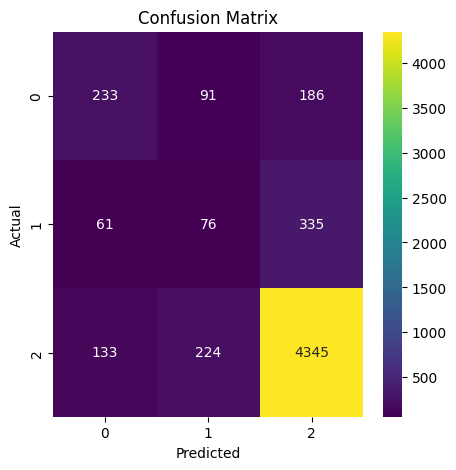

In [ ]:
plt.figure(figsize=(5,5))
sb.heatmap(cm, annot=True, fmt="d", cmap="viridis",
            xticklabels=np.unique(valid_labels),
            yticklabels=np.unique(valid_labels))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

- Classification Report

In [ ]:
print(f"""Classification Report:\n\n{classification_report(y_true=valid_labels,
                                                         y_pred=valid_pred_cv_eno_cust,
                                                         target_names=le.classes_)}""")

Classification Report:

              precision    recall  f1-score   support

    negative       0.55      0.46      0.50       510
     neutral       0.19      0.16      0.18       472
    positive       0.89      0.92      0.91      4702

    accuracy                           0.82      5684
   macro avg       0.54      0.51      0.53      5684
weighted avg       0.80      0.82      0.81      5684



##### Question - Tell me whatever weights i assign, either negative class becomes low or the neutral class becomes low, and neutral class doesn't go above 0.3, please assist.

##### Answer:

You've hit upon a common challenge in machine learning — imbalanced datasets and the difficulty of finding the optimal class weights. It sounds like you're dealing with a situation where one or two classes (negative and/or neutral) have significantly fewer instances than the positive class.

Here's a breakdown of why this might be happening and how to address it:

**Why Class Weights Matter**

- **Imbalanced Datasets:** When one class dominates, the model tends to become biased towards that class. It might achieve high overall accuracy simply by predicting the majority class most of the time, but it will perform poorly on the minority classes.

- **Class Weights:** Assigning higher weights to minority classes helps the model pay more attention to them during training. This counteracts the bias and encourages the model to learn to better distinguish the minority classes.

**Why You Might Be Stuck**

- **Weighting Trade-offs:** Increasing the weight of one class often comes at the expense of another. You're likely seeing a "seesaw effect" where boosting the neutral class lowers the negative class's performance or vice versa.

- **Data Limitations:** Even with careful weighting, the limited number of samples in the minority classes can hinder the model's ability to learn their patterns effectively.

**Potential Solutions**

**1. Fine-grained Weight Adjustment:**

  - **Experiment with smaller increments:** Instead of drastic changes, try making minor adjustments to the weights and observe the impact on each class's performance.
  - **Focus on the F1-score:** This metric balances precision and recall and is particularly useful for imbalanced datasets. Aim to improve the F1-score of the minority classes.

**2. Data Augmentation:**

  - **Oversampling:** Create synthetic samples for the minority classes to balance the dataset. Techniques like SMOTE (Synthetic Minority Over-sampling Technique) can be helpful.
  - **Undersampling:** Reduce the number of samples in the majority class (use with caution, as you might lose valuable information).

**3. Alternative Metrics:**

  - **Precision/Recall:** Depending on your specific needs, focus on optimizing precision (minimize false positives) or recall (minimize false negatives) for the minority classes.
  - **AUC (Area Under the ROC Curve):** A good metric for overall model performance, especially in imbalanced scenarios.

**4. Different Algorithms:**

  - **Ensemble methods (e.g., Random Forest, XGBoost):** These algorithms can sometimes handle imbalanced data more effectively.
  - **Cost-sensitive learning:** Algorithms explicitly consider the cost of misclassifying different classes.

**Debugging Steps**

- **Check for data quality issues:** Ensure your minority class samples are correctly labeled and don't contain noise or errors.
- **Analyze misclassifications:** Examine which classes are being confused with each other to understand the model's weaknesses.
- **Consider feature engineering:** Create new features that might help the model differentiate between classes.

### Emoji - Yes

#### Class Weights - Not Balanced

##### Create pipeline - `pipe_eyes_cv`

In [ ]:
pipe_eyes_cv = Pipeline(
                        [
                          ("Clean_Corpus", CleanCorpusTransformer(emoji=True, stop_words=False)),
                          ("Word_Vectorizer", WordVectors(vectorizer="count")),
                          ("Scaler", StandardScaler(with_mean=False)), # For sparse matrix it should be "with_mean=False"
                          ("Classifier", LogisticRegression(max_iter=1000))
                        ]
                      )

##### Fit pipeline - `pipe_eyes_cv`

In [ ]:
%%time
# CPU times: user 3min 47s, sys: 12.1 s, total: 3min 59s
# Wall time: 4min 7s
pipe_eyes_cv.fit(X=train_reviews, y=train_labels)

CPU times: user 3min 47s, sys: 12.1 s, total: 3min 59s
Wall time: 4min 7s


Pipeline(steps=[('Clean_Corpus',
                 <__main__.CleanCorpusTransformer object at 0x7ce1ea681450>),
                ('Word_Vectorizer',
                 <__main__.WordVectors object at 0x7ce1ea681f60>),
                ('Scaler', StandardScaler(with_mean=False)),
                ('Classifier', LogisticRegression(max_iter=1000))])

##### Predict validation data

In [ ]:
%%time
valid_pred_cv_eyes = pipe_eyes_cv.predict(X=valid_reviews)
valid_pred_cv_eyes

CPU times: user 17.9 s, sys: 254 ms, total: 18.2 s
Wall time: 18.4 s


array([2, 2, 2, ..., 0, 0, 2])

##### Metrics

- Confusion Matrix

In [ ]:
le.classes_

array(['negative', 'neutral', 'positive'], dtype=object)

- There's no direct method within `LabelEncoder` to retrieve the classes as integers instead of their original form, you can achieve this by combining `classes_` and `transform`:

```
from sklearn.preprocessing import LabelEncoder

# Sample labels
labels = ['cat', 'dog', 'cat', 'bird']

# Initialize the encoder
le = LabelEncoder()

# Fit the encoder
le.fit(labels)

# Get integer representation of classes
integer_classes = le.transform(le.classes_)

print(f"Classes in integer form: {integer_classes}")
```

In [ ]:
cm = confusion_matrix(y_true=valid_labels,
                      y_pred=valid_pred_cv_eyes,
                      labels=np.unique(valid_labels))
print(f"Confusion Matrix:\n\n{cm}")

Confusion Matrix:

[[ 249   73  188]
 [  74   65  333]
 [ 167  216 4319]]


- Create a heatmap for better visualization

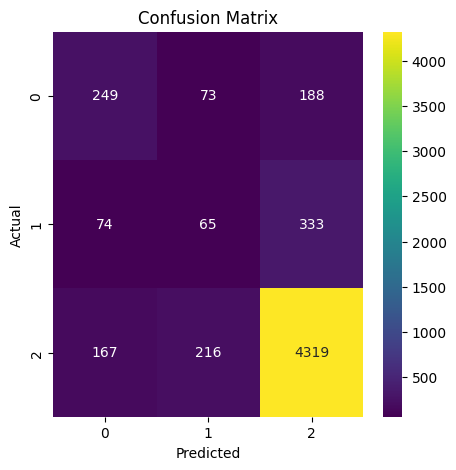

In [ ]:
plt.figure(figsize=(5,5))
sb.heatmap(cm, annot=True, fmt="d", cmap="viridis",
            xticklabels=np.unique(valid_labels),
            yticklabels=np.unique(valid_labels))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

- Classification Report

In [ ]:
print(f"""Classification Report:\n\n{classification_report(y_true=valid_labels,
                                                         y_pred=valid_pred_cv_eyes,
                                                         target_names=le.classes_)}""")

Classification Report:

              precision    recall  f1-score   support

    negative       0.51      0.49      0.50       510
     neutral       0.18      0.14      0.16       472
    positive       0.89      0.92      0.91      4702

    accuracy                           0.82      5684
   macro avg       0.53      0.51      0.52      5684
weighted avg       0.80      0.82      0.81      5684



#### Class Weights - Balanced

##### Create pipeline - `pipe_eyes_cv_bal`

In [ ]:
pipe_eyes_cv_bal = Pipeline(
                        [
                          ("Clean_Corpus", CleanCorpusTransformer(emoji=True, stop_words=False)),
                          ("Word_Vectorizer", WordVectors(vectorizer="count")),
                          ("Scaler", StandardScaler(with_mean=False)), # For sparse matrix it should be "with_mean=False"
                          ("Classifier", LogisticRegression(max_iter=1000, class_weight="balanced"))
                        ]
                      )

##### Fit pipeline - `pipe_eyes_cv_bal`

In [ ]:
%%time
# CPU times: user 2min 58s, sys: 12.4 s, total: 3min 10s
# Wall time: 3min 58s
pipe_eyes_cv_bal.fit(X=train_reviews, y=train_labels)

CPU times: user 3min 44s, sys: 12.6 s, total: 3min 57s
Wall time: 3min 58s


Pipeline(steps=[('Clean_Corpus',
                 <__main__.CleanCorpusTransformer object at 0x7ce1e8f67dc0>),
                ('Word_Vectorizer',
                 <__main__.WordVectors object at 0x7ce1e8f66ef0>),
                ('Scaler', StandardScaler(with_mean=False)),
                ('Classifier',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

##### Predict validation data

In [ ]:
%%time
valid_pred_cv_eyes_bal = pipe_eyes_cv_bal.predict(X=valid_reviews)
valid_pred_cv_eyes_bal

CPU times: user 17.5 s, sys: 254 ms, total: 17.7 s
Wall time: 17.8 s


array([2, 2, 2, ..., 0, 0, 2])

##### Metrics

- Confusion Matrix

In [ ]:
le.classes_

array(['negative', 'neutral', 'positive'], dtype=object)

- There's no direct method within `LabelEncoder` to retrieve the classes as integers instead of their original form, you can achieve this by combining `classes_` and `transform`:

```
from sklearn.preprocessing import LabelEncoder

# Sample labels
labels = ['cat', 'dog', 'cat', 'bird']

# Initialize the encoder
le = LabelEncoder()

# Fit the encoder
le.fit(labels)

# Get integer representation of classes
integer_classes = le.transform(le.classes_)

print(f"Classes in integer form: {integer_classes}")
```

In [ ]:
cm = confusion_matrix(y_true=valid_labels,
                      y_pred=valid_pred_cv_eyes_bal,
                      labels=np.unique(valid_labels))
print(f"Confusion Matrix:\n\n{cm}")

Confusion Matrix:

[[ 278  111  121]
 [  91  116  265]
 [ 255  663 3784]]


- Create a heatmap for better visualization

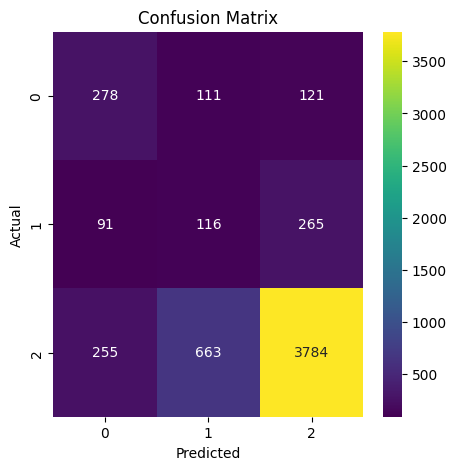

In [ ]:
plt.figure(figsize=(5,5))
sb.heatmap(cm, annot=True, fmt="d", cmap="viridis",
            xticklabels=np.unique(valid_labels),
            yticklabels=np.unique(valid_labels))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

- Classification Report

In [ ]:
print(f"""Classification Report:\n\n{classification_report(y_true=valid_labels,
                                                         y_pred=valid_pred_cv_eyes_bal,
                                                         target_names=le.classes_)}""")

Classification Report:

              precision    recall  f1-score   support

    negative       0.45      0.55      0.49       510
     neutral       0.13      0.25      0.17       472
    positive       0.91      0.80      0.85      4702

    accuracy                           0.74      5684
   macro avg       0.49      0.53      0.50      5684
weighted avg       0.80      0.74      0.76      5684



#### Class Weights - Customized

##### Calculate weights

- Import library

In [ ]:
# from sklearn.utils.class_weight import compute_class_weight
# import numpy as np

- Compute Class Weights

**1. Balanced(same as `class_weight="balanced"` in `Logistis Regression`):**
```
def compute_custom_weights(train_labels):
  classes, counts = np.unique(train_labels, return_counts=True)
  class_weights = 1.0 / counts
  normalized_weights = class_weights / np.sum(class_weights)
  class_weight_dict = {i: weight for i, weight in enumerate(normalized_weights)}
  return class_weight_dict
```

**2. Inverse of class frequency:**
```
def effective_sample_size_weights(train_labels, beta=0.9):
  classes, counts = np.unique(train_labels, return_counts=True)
  eff_n = counts / (1.0 + (counts - 1) * beta)
  weights = eff_n / np.sum(eff_n)
  class_weight_dict = {i: weight for i, weight in enumerate(weights)}
  return class_weight_dict
```

**3. Square Root of Inverse Frequency:**
```
def sqrt_inv_freq_weights(train_labels):
  classes, counts = np.unique(train_labels, return_counts=True)
  weights = 1.0 / np.sqrt(counts)
  normalized_weights = weights / np.sum(weights)
  class_weight_dict = {i: weight for i, weight in enumerate(normalized_weights)}
  return class_weight_dict
```

**4. Inverse of F1-Score:**

`(1)`
```
f1_scores = np.array([0.52, 0.18, 0.90])  # Negative, Neutral, Positive
class_weights = 1.0 / f1_scores
normalized_weights = class_weights / np.sum(class_weights)
class_weight_dict = {i: weight for i, weight in enumerate(normalized_weights)}
print(class_weight_dict)
```
`(2)`

Emphasis on Lowest F1-Score: If you want to particularly focus on improving the "neutral" class, you can further increase its weight.

```
class_weight_dict[1] = class_weight_dict[1] * 2  # Double the weight for "neutral"
normalized_weights = np.array(list(class_weight_dict.values())) / np.sum(list(class_weight_dict.values()))
class_weight_dict = {i: weight for i, weight in enumerate(normalized_weights)}
print(class_weight_dict)
```

These are just examples, and you might need to experiment with different scaling factors or adjustments based on the specific characteristics of your data and model.

**5. Frequency-weighted F1-score:**
```
def freq_weighted_f1_scores(train_labels, f1_scores):
  classes, counts = np.unique(train_labels, return_counts=True)
  weighted_f1 = f1_scores * counts
  inv_weighted_f1 = 1.0 / weighted_f1
  normalized_weights = inv_weighted_f1 / np.sum(inv_weighted_f1)
  class_weight_dict = {i: weight for i, weight in enumerate(normalized_weights)}
  return class_weight_dict

f1_scores = np.array([0.52, 0.18, 0.90])  # Negative, Neutral, Positive
class_weight_dict = freq_weighted_f1_scores(train_labels, f1_scores)
print(class_weight_dict)
```

**6. Balanced + Lowest f1-score:**

```
## Balanced
def compute_custom_weights(train_labels):
  classes, counts = np.unique(train_labels, return_counts=True)
  class_weights = 1.0 / counts
  normalized_weights = class_weights / np.sum(class_weights)
  class_weight_dict = {i: weight for i, weight in enumerate(normalized_weights)}
  return list(class_weight_dict.values())

##  Lowest F1-Score:
class_weight_dict[0] = class_weight_dict[0] * 8  # x15 the weight for "negative"
class_weight_dict[1] = class_weight_dict[1] * 15  # x18 the weight for "neutral"
normalized_weights = np.array(list(class_weight_dict.values())) / np.sum(list(class_weight_dict.values()))
class_weight_dict = {i: weight for i, weight in enumerate(normalized_weights)}

##  Increase weights of minority classes:
class_weight_dict[0] = class_weight_dict[0] * 8  # x15 the weight for "negative"
class_weight_dict[1] = class_weight_dict[1] * 15  # x18 the weight for "neutral"
normalized_weights = np.array(list(class_weight_dict.values())) / np.sum(list(class_weight_dict.values()))
class_weight_dict = {i: weight for i, weight in enumerate(normalized_weights)}
print(class_weight_dict)
```

- Create a dictionary

In [ ]:
## Inverse of F1-Score
f1_scores = np.array([0.52, 0.18, 0.90])  # Negative, Neutral, Positive
class_weights = 1.0 / f1_scores
normalized_weights = class_weights / np.sum(class_weights)
class_weight_dict = {i: weight for i, weight in enumerate(normalized_weights)}

class_weight_dict[1] = class_weight_dict[1] * 2  # Double the weight for "neutral"
normalized_weights = np.array(list(class_weight_dict.values())) / np.sum(list(class_weight_dict.values()))
class_weight_dict = {i: weight for i, weight in enumerate(normalized_weights)}

In [ ]:
class_weight_dict

{0: 0.13595166163141992, 1: 0.7854984894259819, 2: 0.0785498489425982}

##### Create pipeline - `pipe_eyes_cv_cust`

In [ ]:
pipe_eyes_cv_cust = Pipeline(
                        [
                          ("Clean_Corpus", CleanCorpusTransformer(emoji=False, stop_words=False)),
                          ("Word_Vectorizer", WordVectors(vectorizer="count")),
                          ("Scaler", StandardScaler(with_mean=False)), # For sparse matrix it should be "with_mean=False"
                          ("Classifier", LogisticRegression(max_iter=1000, class_weight=class_weight_dict))
                        ]
                      )

##### Fit pipeline - `pipe_eyes_cv_cust`

In [ ]:
%%time
# CPU times: user 2min 35s, sys: 8.8 s, total: 2min 44s
# Wall time: 2min 34s
pipe_eyes_cv_cust.fit(X=train_reviews, y=train_labels)

CPU times: user 2min 49s, sys: 7.82 s, total: 2min 57s
Wall time: 3min 10s


Pipeline(steps=[('Clean_Corpus',
                 <__main__.CleanCorpusTransformer object at 0x7ce1e90cfa60>),
                ('Word_Vectorizer',
                 <__main__.WordVectors object at 0x7ce1e84d3af0>),
                ('Scaler', StandardScaler(with_mean=False)),
                ('Classifier',
                 LogisticRegression(class_weight={0: 0.13595166163141992,
                                                  1: 0.7854984894259819,
                                                  2: 0.0785498489425982},
                                    max_iter=1000))])

##### Predict validation data

In [ ]:
%%time
valid_pred_cv_eyes_cust = pipe_eyes_cv_cust.predict(X=valid_reviews)
valid_pred_cv_eyes_cust

CPU times: user 16.2 s, sys: 258 ms, total: 16.5 s
Wall time: 19.1 s


array([2, 2, 2, ..., 0, 0, 2])

##### Metrics

- Confusion Matrix

In [ ]:
le.classes_

array(['negative', 'neutral', 'positive'], dtype=object)

- There's no direct method within `LabelEncoder` to retrieve the classes as integers instead of their original form, you can achieve this by combining `classes_` and `transform`:

```
from sklearn.preprocessing import LabelEncoder

# Sample labels
labels = ['cat', 'dog', 'cat', 'bird']

# Initialize the encoder
le = LabelEncoder()

# Fit the encoder
le.fit(labels)

# Get integer representation of classes
integer_classes = le.transform(le.classes_)

print(f"Classes in integer form: {integer_classes}")
```

In [ ]:
cm = confusion_matrix(y_true=valid_labels,
                      y_pred=valid_pred_cv_eyes_cust,
                      labels=np.unique(valid_labels))
print(f"Confusion Matrix:\n\n{cm}")

Confusion Matrix:

[[ 198  180  132]
 [  59  139  274]
 [ 138  595 3969]]


- Create a heatmap for better visualization

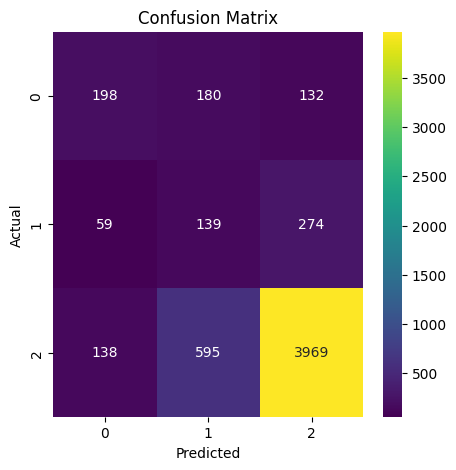

In [ ]:
plt.figure(figsize=(5,5))
sb.heatmap(cm, annot=True, fmt="d", cmap="viridis",
            xticklabels=np.unique(valid_labels),
            yticklabels=np.unique(valid_labels))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

- Classification Report

In [ ]:
print(f"""Classification Report:\n\n{classification_report(y_true=valid_labels,
                                                         y_pred=valid_pred_cv_eyes_cust,
                                                         target_names=le.classes_)}""")

Classification Report:

              precision    recall  f1-score   support

    negative       0.50      0.39      0.44       510
     neutral       0.15      0.29      0.20       472
    positive       0.91      0.84      0.87      4702

    accuracy                           0.76      5684
   macro avg       0.52      0.51      0.50      5684
weighted avg       0.81      0.76      0.78      5684



##### Question - Can you define the above function such that we take random base score (according to class counts) and iterate it for certain rounds and select best score among them to calculate weights, and it should generalize well irrespective of number of classes?

##### Answer:
```
import numpy as np
import random

def freq_weighted_f1_scores(train_labels, f1_scores):
  """Calculates frequency-weighted F1-scores based on provided base scores.

  Args:
    train_labels: A list or array of class labels.
    f1_scores: A list or array of base F1-scores for each class.

  Returns:
    A dictionary mapping class indices to their corresponding weights.
  """
  classes, counts = np.unique(train_labels, return_counts=True)
  weighted_f1 = f1_scores * counts
  inv_weighted_f1 = 1.0 / weighted_f1
  normalized_weights = inv_weighted_f1 / np.sum(inv_weighted_f1)
  class_weight_dict = {i: weight for i, weight in enumerate(normalized_weights)}
  return class_weight_dict

def find_best_f1_scores(train_labels, num_iterations=10, score_range=(0.1, 0.9)):
  """Finds the best base F1-scores using random search and iteration.

  Args:
    train_labels: A list or array of class labels.
    num_iterations: The number of iterations for random search.
    score_range: The range for generating random base F1-scores.

  Returns:
    A list of base F1-scores that yield the highest average F1-score
    across all classes.
  """
  best_f1_scores = None
  best_avg_f1 = 0

  classes, counts = np.unique(train_labels, return_counts=True)
  num_classes = len(classes)

  for _ in range(num_iterations):
    f1_scores = [random.uniform(*score_range) for _ in range(num_classes)]
    class_weights = freq_weighted_f1_scores(train_labels, f1_scores)
    # Here, you would train and evaluate your model with these weights
    # and obtain the F1-scores for each class (replace with your actual evaluation)
    # For this example, let's assume a simplified evaluation:
    f1_scores_after_training = [class_weights[i] * counts[i] for i in range(num_classes)]
    avg_f1 = np.mean(f1_scores_after_training)

    if avg_f1 > best_avg_f1:
      best_avg_f1 = avg_f1
      best_f1_scores = f1_scores

  return best_f1_scores

# Example usage
train_labels = [0, 2, 2, 1, 2, 0, 2, 2, 2, 0]
best_f1_scores = find_best_f1_scores(train_labels, num_iterations=50)
print(f"Best base F1-scores: {best_f1_scores}")

class_weight_dict = freq_weighted_f1_scores(train_labels, best_f1_scores)
print(f"Class weight dictionary: {class_weight_dict}")
```

**Explanation:**

**1. `freq_weighted_f1_scores` Function:** This function remains the same as before, calculating weights based on provided F1-scores and class frequencies.

**`find_best_f1_scores` Function:**
  - Takes `train_labels`, num_iterations, and score_range as input.
  - Initializes `best_f1_scores` and `best_avg_f1` to keep track of the best scores found.
  - Iterates `num_iterations` times:
    - Generates random F1-scores for each class within the `score_range`.
    - Calculates class weights using `freq_weighted_f1_scores`.
    - (Important): Here, you would insert your model training and evaluation logic using the generated weights. The example uses a simplified evaluation for demonstration.
    - Calculates the average F1-score across all classes.
    - Updates `best_f1_scores` and `best_avg_f1` if a better average F1-score is found.
  - Returns the `best_f1_scores`.

**Key Improvements:**

- **Generalization:** Works for any number of classes by determining the number of classes dynamically.
- **Random Search:** Explores different base F1-score combinations randomly within a specified range.
- **Iteration:** Repeats the process for a defined number of iterations to increase the chances of finding good base scores.

**How to Use:**

**1. Replace the Simplified Evaluation:** Replace the placeholder evaluation logic with your actual model training and evaluation process. Use the `class_weights` dictionary in your model training.

**2. Experiment with Parameters:** Adjust `num_iterations` and score_range to control the search space and computational cost.

This approach automates the search for good base F1-scores, but remember that the effectiveness still depends on the quality of your model and evaluation process.

##### Question - I will be creating a class which will assign class weights for imbalanced datasets, i will be using these functions as methods, there are few more functions you mentioned i will be adding those in the class as well.

##### Answer:

Here's a basic structure you could consider for your class:

```
import numpy as np
import random

class ClassWeights:
    def __init__(self, train_labels):
        self.train_labels = train_labels
        self.classes, self.counts = np.unique(train_labels, return_counts=True)

    def balanced(self):
        # Implementation of balanced weights (same as class_weight="balanced")
        class_weights = 1.0 / self.counts
        normalized_weights = class_weights / np.sum(class_weights)
        class_weight_dict = {i: weight for i, weight in enumerate(normalized_weights)}
        return class_weight_dict

    def sqrt_inv_freq_weights(self):
        # Implementation of square root of inverse frequency weights
        weights = 1.0 / np.sqrt(self.counts)
        normalized_weights = weights / np.sum(weights)
        class_weight_dict = {i: weight for i, weight in enumerate(normalized_weights)}
        return class_weight_dict

    def freq_weighted_f1_scores(self, f1_scores):
        # Implementation of frequency-weighted F1-scores
        weighted_f1 = f1_scores * self.counts
        inv_weighted_f1 = 1.0 / weighted_f1
        normalized_weights = inv_weighted_f1 / np.sum(inv_weighted_f1)
        class_weight_dict = {i: weight for i, weight in enumerate(normalized_weights)}
        return class_weight_dict

    def find_best_f1_scores(self, num_iterations=10, score_range=(0.1, 0.9)):
        # Implementation of finding best base F1-scores
        best_f1_scores = None
        best_avg_f1 = 0

        num_classes = len(self.classes)

        for _ in range(num_iterations):
            f1_scores = [random.uniform(*score_range) for _ in range(num_classes)]
            class_weights = self.freq_weighted_f1_scores(f1_scores)
            # ... (Your model training and evaluation logic here) ...
            f1_scores_after_training = [class_weights[i] * self.counts[i] for i in range(num_classes)]
            avg_f1 = np.mean(f1_scores_after_training)

            if avg_f1 > best_avg_f1:
                best_avg_f1 = avg_f1
                best_f1_scores = f1_scores

        return best_f1_scores

    # Add other methods for different weighting techniques here (e.g., effective sample size weights)

# Example Usage:
train_labels = [0, 2, 2, 1, 2, 0, 2, 2, 2, 0]
cw = ClassWeights(train_labels)
balanced_weights = cw.balanced()
sqrt_inv_freq_weights = cw.sqrt_inv_freq_weights()
# ... (You can call other methods similarly)

best_f1_scores = cw.find_best_f1_scores(num_iterations=50)
# ... (Use best_f1_scores to calculate weights using freq_weighted_f1_scores)
```

**Key points and potential enhancements:**

- **Constructor (__init__):** Takes train_labels as input and calculates classes and counts.
- **Methods:** Each weighting technique is implemented as a separate method, making it easy to call and compare different approaches.
- **`find_best_f1_scores`:** This method remains largely the same, but it now uses `self.freq_weighted_f1_scores`. Remember to replace the placeholder evaluation with your actual model training and assessment.
- **Extensibility:** Add more methods for other weighting techniques like `effective_sample_size_weights`, as you mentioned.
- **Error Handling:** You might consider adding error handling to ensure the input `train_labels` is valid and to handle potential issues during weight calculation.
- **Documentation:** Provide clear docstrings for the class and its methods.

##### Question - Will it be good to create a method such that it will use all the weighing methods in the class and give out best method among them?

##### Answer:

Here's how you could implement such a method:

```
import numpy as np
import random

# ... (rest of your ClassWeights class code)

    def find_best_method(self, model, X_train, y_train, X_val, y_val,
                          num_iterations=10, score_range=(0.1, 0.9), metric='f1_weighted'):
        """
        Finds the best weighting method among available methods in the class.

        Args:
            model: The machine learning model to use for evaluation.
            X_train: Training data features.
            y_train: Training data labels.
            X_val: Validation data features.
            y_val: Validation data labels.
            num_iterations: Number of iterations for random search (if applicable).
            score_range: Range for random base F1-scores (if applicable).
            metric: Evaluation metric ('f1_weighted', 'accuracy', etc.).

        Returns:
            A dictionary containing the best method name and its corresponding weights.
        """

        best_method = None
        best_weights = None
        best_score = 0

        methods = [
            self.balanced,
            self.sqrt_inv_freq_weights,
            # Add other methods here
        ]

        for method in methods:
            if method.__name__ == 'freq_weighted_f1_scores':
                best_f1_scores = self.find_best_f1_scores(num_iterations, score_range)
                weights = self.freq_weighted_f1_scores(best_f1_scores)
            else:
                weights = method()

            # Train and evaluate the model with the current weights
            model.fit(X_train, y_train, class_weight=weights)
            y_pred = model.predict(X_val)
            score = self._evaluate(y_val, y_pred, metric)

            if score > best_score:
                best_score = score
                best_method = method.__name__
                best_weights = weights

        return {'method': best_method, 'weights': best_weights}

    def _evaluate(self, y_true, y_pred, metric):
        # Helper function to calculate evaluation score
        if metric == 'f1_weighted':
            from sklearn.metrics import f1_score
            return f1_score(y_true, y_pred, average='weighted')
        elif metric == 'accuracy':
            from sklearn.metrics import accuracy_score
            return accuracy_score(y_true, y_pred)
        # Add other metrics as needed

# Example Usage
# ... (Assuming you have X_train, y_train, X_val, y_val, and a model)
cw = ClassWeights(y_train)
best_result = cw.find_best_method(model, X_train, y_train, X_val, y_val)
print(f"Best method: {best_result['method']}, Weights: {best_result['weights']}")
```

**Explanation:**

**1. `find_best_method`:**

  - Takes the model, training and validation data, and evaluation metric as input.
  - Defines a list of methods containing all the weighting methods from your class.
  - Iterates through each method:
    - Calculates the weights using the method (special handling for `freq_weighted_f1_scores`).
    - Trains the model using the calculated weights.
    - Evaluates the model on the validation set using the specified `metric`.
    - Tracks the best score and corresponding method/weights.
  - Returns a dictionary containing the best method's name and weights.

**2. `_evaluate`:**

A helper function to calculate the evaluation score based on the chosen `metric`.

Now you have a convenient way to automatically find the most effective class weighting technique for your imbalanced dataset! Remember to add any new weighting methods you create to the methods list in `find_best_method`.

### Stopwords - No

#### Class Weights - Not Balanced

#### Class Weights - Balanced

#### Class Weights - Customized

## TF-IDF Vectorizer

### Emoji - No

### Emoji - Yes

### Stopwords - No

## Word2vec

### Gensim Word2Vec - Manual

#### Emoji - No

##### Class Weights - Not Balanced

##### Class Weights - Balanced

##### Class Weights - Customized

#### Emoji - Yes

##### Class Weights - Not Balanced

##### Class Weights - Balanced

##### Class Weights - Customized

#### Stopwords - No

##### Class Weights - Not Balanced

##### Class Weights - Balanced

##### Class Weights - Customized

### Gensim Word2Vec - Pre-trained

#### Emoji - No

##### Class Weights - Not Balanced

##### Class Weights - Balanced

##### Class Weights - Customized

#### Emoji - Yes

##### Class Weights - Not Balanced

##### Class Weights - Balanced

##### Class Weights - Customized

#### Stopwords - No

##### Class Weights - Not Balanced

##### Class Weights - Balanced

##### Class Weights - Customized

# Converting txt file into pdf file

In [ ]:
!pip install markdown2 weasyprint

In [ ]:
import markdown2
from weasyprint import HTML

# Read the contents of the text file
with open('/content/Classes_related_conversation_with_gemini.txt', 'r', encoding='utf-8') as file:
    text_content = file.read()

# Convert text content to markdown
markdown_content = markdown2.markdown(text_content)

# Convert markdown content to HTML
html_content = markdown_content

# Path for the output PDF file
output_path = "Classes_related_conversation_with_gemini.pdf"

# Convert HTML to PDF using WeasyPrint
HTML(string=html_content).write_pdf(output_path)

print(f"PDF successfully generated at {output_path}")


## Getting corpus and evaluations

In [ ]:


clf_names="""sklearn.naive_bayes.MultinomialNB
sklearn.naive_bayes.BernoulliNB
sklearn.naive_bayes.CategoricalNB
sklearn.naive_bayes.ComplementNB
sklearn.linear_model.LogisticRegression (with multi_class='multinomial' or multi_class='ovr')
sklearn.linear_model.RidgeClassifier
sklearn.linear_model.SGDClassifier (with loss='hinge' or other multi-class losses)
sklearn.ensemble.RandomForestClassifier
sklearn.ensemble.ExtraTreesClassifier
sklearn.ensemble.BaggingClassifier
sklearn.ensemble.AdaBoostClassifier
sklearn.ensemble.GradientBoostingClassifier
sklearn.ensemble.HistGradientBoostingClassifier
sklearn.ensemble.VotingClassifier
XGBoost
LightGBM
"""

In [ ]:
clf_names_list = clf_names.split("\n")
clf_names_list

['sklearn.naive_bayes.MultinomialNB',
 'sklearn.naive_bayes.BernoulliNB',
 'sklearn.naive_bayes.CategoricalNB',
 'sklearn.naive_bayes.ComplementNB',
 "sklearn.linear_model.LogisticRegression (with multi_class='multinomial' or multi_class='ovr')",
 'sklearn.linear_model.RidgeClassifier',
 "sklearn.linear_model.SGDClassifier (with loss='hinge' or other multi-class losses)",
 'sklearn.ensemble.RandomForestClassifier',
 'sklearn.ensemble.ExtraTreesClassifier',
 'sklearn.ensemble.BaggingClassifier',
 'sklearn.ensemble.AdaBoostClassifier',
 'sklearn.ensemble.GradientBoostingClassifier',
 'sklearn.ensemble.HistGradientBoostingClassifier',
 'sklearn.ensemble.VotingClassifier',
 'XGBoost',
 'LightGBM',
 '']

In [ ]:
clfs = []
for i in clf_names_list:
  if i != "":
    clfs.append(i.split(".")[-1])
clfs

['MultinomialNB',
 'BernoulliNB',
 'CategoricalNB',
 'ComplementNB',
 "LogisticRegression (with multi_class='multinomial' or multi_class='ovr')",
 'RidgeClassifier',
 "SGDClassifier (with loss='hinge' or other multi-class losses)",
 'RandomForestClassifier',
 'ExtraTreesClassifier',
 'BaggingClassifier',
 'AdaBoostClassifier',
 'GradientBoostingClassifier',
 'HistGradientBoostingClassifier',
 'VotingClassifier',
 'XGBoost',
 'LightGBM']

In [ ]:
print(clfs)

['MultinomialNB', 'BernoulliNB', 'CategoricalNB', 'ComplementNB', "LogisticRegression (with multi_class='multinomial' or multi_class='ovr')", 'RidgeClassifier', "SGDClassifier (with loss='hinge' or other multi-class losses)", 'RandomForestClassifier', 'ExtraTreesClassifier', 'BaggingClassifier', 'AdaBoostClassifier', 'GradientBoostingClassifier', 'HistGradientBoostingClassifier', 'VotingClassifier', 'XGBoost', 'LightGBM']


- Without balancing weights

In [ ]:
pipe = Pipeline(
                        [
                          ("Clean_Corpus", CleanCorpusTransformer(emoji=False, stop_words=False)),
                          ("Word_Vectorizer", WordVectors(vectorizer="count")),
                          ("Scaler", StandardScaler(with_mean=False)), # For sparse matrix it should be "with_mean=False"
                          ("Classifier", LogisticRegression(max_iter=1000, class_weight=class_weight_dict))
                        ]
                      )

- With balancing weights

In [ ]:
pipe_bal = Pipeline(
                        [
                          ("Clean_Corpus", CleanCorpusTransformer(emoji=False, stop_words=False)),
                          ("Word_Vectorizer", WordVectors(vectorizer="count")),
                          ("Scaler", StandardScaler(with_mean=False)), # For sparse matrix it should be "with_mean=False"
                          ("weights", ClassWeightsTransformer()),
                          ("Classifier", LogisticRegression(max_iter=10000000)),
                        ]
                      )

In [ ]:
%%time

pipe_bal.fit(X=train_reviews, y=train_labels)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Best weights: {0: 0.4320892226758567, 1: 0.4384759518498002, 2: 0.12943482547434318}
CPU times: user 3min 51s, sys: 26.7 s, total: 4min 18s
Wall time: 3min 44s


Pipeline(steps=[('Clean_Corpus',
                 <__main__.CleanCorpusTransformer object at 0x786cb94c3820>),
                ('Word_Vectorizer',
                 <__main__.WordVectors object at 0x786c6dd6e1a0>),
                ('Scaler', StandardScaler(with_mean=False)),
                ('weights',
                 <__main__.ClassWeightsTransformer object at 0x786c6dd6fac0>),
                ('Classifier', LogisticRegression(max_iter=10000000))])

In [ ]:
from sklearn.naive_bayes import MultinomialNB

In [ ]:
mb = clfs[0]+"()"

In [ ]:
mb

'MultinomialNB()'

In [ ]:
eval(mb)

MultinomialNB()

In [ ]:
def safe_eval(expression):
  """Evaluates a string expression if it contains only allowed characters."""
  allowed_chars = set("abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789_()")
  if set(expression).issubset(allowed_chars):
    return eval(expression)
  else:
    return "Potentially unsafe expression"


'Potentially unsafe expression'

In [ ]:
# Example usage
safe_eval("MultinomialNB()")  # Safe

MultinomialNB()

In [ ]:
safe_eval("__import__('os').system('rm -rf /')")  # Unsafe

'Potentially unsafe expression'

In [ ]:
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, CategoricalNB, ComplementNB
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier, VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

models = {
    'MultinomialNB': MultinomialNB,
    'BernoulliNB': BernoulliNB,
    'CategoricalNB': CategoricalNB,
    'ComplementNB': ComplementNB,
    'LogisticRegression': lambda: LogisticRegression(multi_class='multinomial', random_state=42),
    'RidgeClassifier': RidgeClassifier,
    'SGDClassifier': lambda: SGDClassifier(loss='hinge', random_state=42),
    'RandomForestClassifier': lambda: RandomForestClassifier(random_state=42),
    'ExtraTreesClassifier': lambda: ExtraTreesClassifier(random_state=42),
    'BaggingClassifier': lambda: BaggingClassifier(random_state=42),
    'AdaBoostClassifier': AdaBoostClassifier,
    'GradientBoostingClassifier': lambda: GradientBoostingClassifier(random_state=42),
    'HistGradientBoostingClassifier': HistGradientBoostingClassifier,
    # Note: VotingClassifier doesn't have a class_weight parameter directly,
    # but you can set it for the individual estimators within it.
    'XGBClassifier': lambda: XGBClassifier(random_state=42),
    'LGBMClassifier': lambda: LGBMClassifier(random_state=42),
}

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
models_list = list(models.keys())
models_list

['MultinomialNB',
 'BernoulliNB',
 'CategoricalNB',
 'ComplementNB',
 'LogisticRegression',
 'RidgeClassifier',
 'SGDClassifier',
 'RandomForestClassifier',
 'ExtraTreesClassifier',
 'BaggingClassifier',
 'AdaBoostClassifier',
 'GradientBoostingClassifier',
 'HistGradientBoostingClassifier',
 'XGBClassifier',
 'LGBMClassifier']

In [ ]:
len(models.keys())

15

In [ ]:
len(clfs)

16

## Remember: Function/class should return results as a dataframe, there should be option f returning corpus (like emoji-yes, stopwords-no corpus etc)